In [1]:
import sys
sys.path.insert(0, "/Users/rstiskalek/Projects/candel")

import numpyro
numpyro.set_host_device_count(4)

import numpy as np
from scipy.stats import norm
from scipy.integrate import simpson as simpson_scipy
from scipy.integrate import cumulative_simpson as cum_simpson_scipy

from tqdm import trange

from jax import numpy as jnp
from jax import random
from jax.scipy.stats.norm import logcdf as jax_norm_logcdf
from jax.scipy.stats.norm import cdf as jax_norm_cdf
from jax.scipy.special import logsumexp
from numpyro import plate, sample, factor
from numpyro.distributions import Normal, Uniform
from numpyro.infer import MCMC, NUTS, init_to_median
from quadax import simpson


import candel
from candel import SPEED_OF_LIGHT
from candel.model import LOSInterpolator

import matplotlib.pyplot as plt
%matplotlib inline


def r2mu(r):
    return 5 * jnp.log10(r) + 25

def mu2r(mu):
    return 10**((mu - 25) / 5)

def r2czcosmo(r, H0=70):
    return r * H0

In [2]:
config_path = "/Users/rstiskalek/Projects/CANDEL/scripts/runs/config_shoes.toml"
config = candel.load_config(config_path)

reconstruction = "Carrick2015"
nsim = 0

loader_C15 = candel.field.name2field_loader(reconstruction)(
    nsim=nsim, **config["io"]["reconstruction_main"][reconstruction])


2025-08-20 14:02:39 replacing prior of `beta` with a delta function.


Retained 53 out of 1300 points.


/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_10232/2222700232.py:94: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


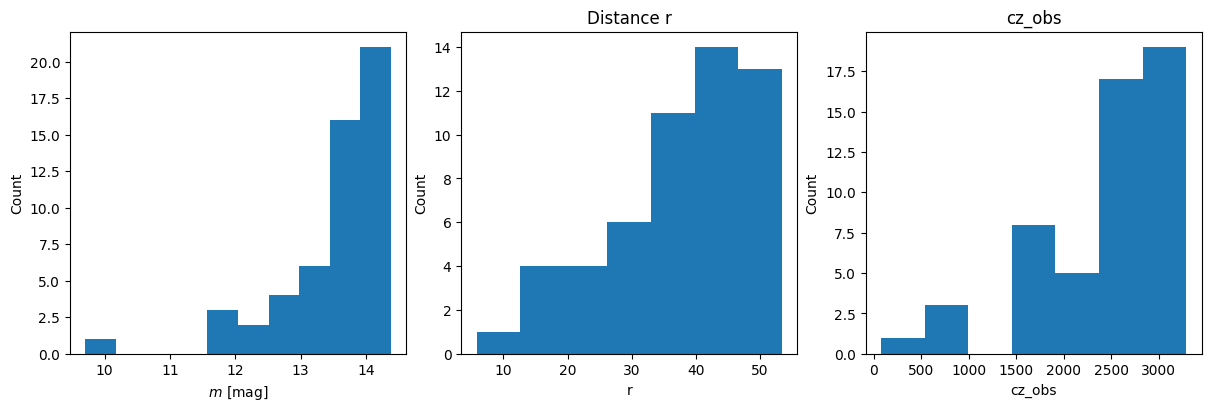

In [3]:
npoints = 1300

Rmax = 150
M = -19.25
sigma_v = 250
e_mag = 0.1
H0 = 70
mag_lim = None
cz_lim = 3300

r_grid = np.linspace(1e-4, Rmax, 300)
loader = loader_C15
beta = 0.43


def sample_distance_inhomogeneous(r_grid, los_density, gen):
    pi_r = los_density * r_grid**2
    cdf_r = cum_simpson_scipy(pi_r, x=r_grid, initial=0)
    cdf_r /= cdf_r[-1]
    return np.interp(gen.uniform(), cdf_r, r_grid)


def generate_rand_los(seed, npoints, loader):
    gen = np.random.default_rng(seed)
    RA = gen.uniform(0, 360, size=npoints)
    dec = np.arcsin(gen.uniform(-1, 1, size=npoints)) * 180 / np.pi
    los_density, los_velocity = candel.field.interpolate_los_density_velocity(
        loader, r_grid, RA, dec, verbose=False)
    return los_density, beta * los_velocity


def generate_mock(seed, mag_lim=None, cz_lim=None, verbose=False,
                  make_plot=False, mag_lim_width=0.5, ):
    gen = np.random.default_rng(seed)

    los_velocity_r = np.zeros(npoints)
    if loader is not None:
        r = np.full(npoints, np.nan)

        RA = gen.uniform(0, 360, size=npoints)
        dec = np.arcsin(gen.uniform(-1, 1, size=npoints)) * 180 / np.pi
        los_density, los_velocity = candel.field.interpolate_los_density_velocity(
            loader, r_grid, RA, dec, verbose=False)
        los_velocity *= beta

        for i in range(npoints):
            los_density_i = los_density[i]
            los_velocity_i = los_velocity[i]

            r[i] = sample_distance_inhomogeneous(r_grid, los_density_i, gen)
            los_density[i] = los_density_i
            los_velocity[i] = los_velocity_i
            los_velocity_r[i] = np.interp(r[i], r_grid, los_velocity_i)
    else:
        r = Rmax * gen.uniform(0, 1, npoints)**(1/3)
        los_density = np.full((npoints, len(r_grid)), 1.0 )
        los_velocity = np.full((npoints, len(r_grid)), 0.)

    mag = gen.normal(r2mu(r) + M, e_mag, )
    z_cosmo = r2czcosmo(r, H0) / SPEED_OF_LIGHT

    cz = gen.normal(((1 + z_cosmo) * (1 + los_velocity_r / SPEED_OF_LIGHT) - 1) * SPEED_OF_LIGHT, sigma_v)

    mask = np.ones_like(mag, dtype=bool)
    if mag_lim is not None:
        # p_sel = 1 - norm(loc=mag_lim, scale=mag_lim_width).cdf(mag)
        # mask &= p_sel > gen.random(npoints)
        mask &= mag < mag_lim
    if cz_lim is not None:
        mask &= cz < cz_lim
  
    if verbose:
        print(f"Retained {np.sum(mask)} out of {npoints} points.")

    mag, cz, r = mag[mask], cz[mask], r[mask]
    los_density, los_velocity = los_density[mask], los_velocity[mask]

    if make_plot:
        fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
        axes[0].hist(mag, bins="auto")
        axes[0].set_xlabel(r"$m ~ [\mathrm{mag}]$")
        axes[0].set_ylabel('Count')

        axes[1].hist(r, bins="auto")
        axes[1].set_title(r'Distance r')
        axes[1].set_xlabel('r')
        axes[1].set_ylabel('Count')

        axes[2].hist(cz, bins="auto")
        axes[2].set_title('cz_obs')
        axes[2].set_xlabel('cz_obs')
        axes[2].set_ylabel('Count')

        fig.show()

    return mag, cz, r, los_density, los_velocity
  

__ = generate_mock(2, mag_lim, cz_lim, verbose=True, make_plot=True)

In [9]:
class FluxSelectionModel:

    def __init__(self, mag_lim, e_mag, Rmax_survey, sigma_v, H0, los_r, los_density, los_velocity, **kwargs):
        self.mag_lim = mag_lim
        self.e_mag = e_mag
        self.Rmax_survey = Rmax_survey
        self.sigma_v = sigma_v
        self.H0 = H0

        self.los_r = jnp.asarray(los_r)
        self.los_density = jnp.asarray(los_density)[0]
        self.los_velocity = jnp.asarray(los_velocity)[0]

        self.f_los_density = LOSInterpolator(los_r, los_density)
        self.f_los_velocity = LOSInterpolator(los_r, los_velocity)

    def __call__(self, mag_obs, cz_obs):
        N = len(mag_obs)

        M = sample('M', Normal(-19.25, 1.0))

        lp_norm = jnp.log(simpson(self.los_density * self.los_r[None, :]**2, x=self.los_r, axis=-1))

        # The shape is `(num_samples, num_r_grid, )`
        log_pi_r = 2 * jnp.log(self.los_r[None, :]) + jnp.log(self.los_density) - lp_norm[:, None]
        mag_pred = r2mu(self.los_r)[None, :] + M

        log_sel = jax_norm_logcdf((mag_lim - mag_pred) / self.e_mag) + log_pi_r
        log_sel = jnp.log(simpson(jnp.exp(log_sel), x=self.los_r, axis=-1))
        factor("log_sel", -jnp.sum(log_sel))

        # factor("global_norm", N * 0.6 * jnp.log(10) * M)

        with plate('galaxies_lp', N):
            r = sample('r', Uniform(0, self.Rmax_survey))
            rho = self.f_los_density(r)[0]
            factor("log_r", 2 * jnp.log(r) + jnp.log(rho) - lp_norm)

        mu_r = 5 * jnp.log10(r) + 25
        m_mean = mu_r + M
        Vpec = self.f_los_velocity(r)[0]

        z_cosmo = r2czcosmo(r, H0=H0) / SPEED_OF_LIGHT
        cz = ((1 + z_cosmo) * (1 + Vpec / SPEED_OF_LIGHT) - 1) * SPEED_OF_LIGHT

        with plate('galaxies_ll', N):
            sample('mag_obs', Normal(m_mean, self.e_mag), obs=mag_obs)
            sample('cz_obs', Normal(cz, sigma_v), obs=cz_obs)


class RedshiftSelectionModel:

    def __init__(self, cz_lim, e_mag, Rmax_survey, sigma_v, M, los_r,
                 los_density, los_velocity, rand_los_density, rand_los_velocity, **kwargs):
        self.cz_lim = cz_lim
        self.e_mag = e_mag
        self.Rmax_survey = Rmax_survey
        self.sigma_v = sigma_v
        self.M = M

        self.los_r = jnp.asarray(los_r)
        self.los_density = jnp.asarray(los_density)[0]
        self.los_velocity = jnp.asarray(los_velocity)[0]

        self.f_los_density = LOSInterpolator(los_r, los_density)
        self.f_los_velocity = LOSInterpolator(los_r, los_velocity)

        self.rand_los_density = jnp.asarray(rand_los_density)[0]
        self.rand_los_velocity = jnp.asarray(rand_los_velocity)[0]

    def __call__(self, mag_obs, cz_obs, ):
        N = len(mag_obs)

        H0 = sample('H0', Uniform(1, 100))

        lp_norm = jnp.log(simpson(self.los_density * self.los_r[None, :]**2, x=self.los_r, axis=-1))

        # The shape is `(num_samples, num_r_grid, )`
        # log_pi_r = 2 * jnp.log(self.los_r[None, :]) + jnp.log(self.los_density) - lp_norm[:, None]
        # cz_pred = ((1 + r2czcosmo(self.los_r, H0=H0)[None, :] / SPEED_OF_LIGHT) * (1 + self.los_velocity / SPEED_OF_LIGHT) - 1) * SPEED_OF_LIGHT

        # log_sel = jax_norm_logcdf((cz_lim - cz_pred) / sigma_v) + log_pi_r
        # log_sel = jnp.log(simpson(jnp.exp(log_sel), x=self.los_r, axis=-1))
        # factor("log_sel", -jnp.sum(log_sel))


        lp_norm_rand = jnp.log(simpson(self.rand_los_density * self.los_r[None, :]**2, x=self.los_r, axis=-1))
        # The shape is `(num_samples, num_r_grid, )`
        log_pi_r = 2 * jnp.log(self.los_r[None, :]) + jnp.log(self.rand_los_density) - lp_norm_rand[:, None]
        cz_pred = ((1 + r2czcosmo(self.los_r, H0=H0)[None, :] / SPEED_OF_LIGHT) * (1 + self.rand_los_velocity / SPEED_OF_LIGHT) - 1) * SPEED_OF_LIGHT

        log_sel = jax_norm_logcdf((cz_lim - cz_pred) / sigma_v) + log_pi_r
        log_sel = jnp.log(simpson(jnp.exp(log_sel), x=self.los_r, axis=-1))
        log_sel = logsumexp(log_sel) - jnp.log(len(self.rand_los_density))
        factor("log_sel", - N * log_sel)

        # factor("global_norm", 3 * N * jnp.log(H0))

        with plate('galaxies_lp', N):
            r = sample('r', Uniform(0, self.Rmax_survey))
            rho = self.f_los_density(r)[0]
            factor("log_r", 2 * jnp.log(r) + jnp.log(rho) - lp_norm)

        mu_r = 5 * jnp.log10(r) + 25
        m_mean = mu_r + self.M

        Vpec = self.f_los_velocity(r)[0]

        z_cosmo = r2czcosmo(r, H0=H0) / SPEED_OF_LIGHT
        cz = ((1 + z_cosmo) * (1 + Vpec / SPEED_OF_LIGHT) - 1) * SPEED_OF_LIGHT

        with plate('galaxies_ll', N):
            sample('mag_obs', Normal(m_mean, self.e_mag), obs=mag_obs)
            sample('cz_obs', Normal(cz, sigma_v), obs=cz_obs)

In [14]:
num_warmup = 500
num_steps = 1500

num_rand = 250

# NOTE: Make sure to switch the mock generator to be generating magnitude limited mocks!

model_const = RedshiftSelectionModel
param_bias_test = "H0"

# model_const = FluxSelectionModel
# param_bias_test = "M"

nrepeat = 100
progress_bar = nrepeat == 1

bias = []

for i in trange(nrepeat, desc="Running MCMC", disable=progress_bar):
    mag, cz, r, los_density, los_velocity = generate_mock(500 + i, mag_lim=mag_lim, cz_lim=cz_lim)
    los_density = los_density[None, ...]
    los_velocity = los_velocity[None, ...]

    rand_los_density, rand_los_velocity = generate_rand_los(i + 1000, num_rand, loader)
    rand_los_density = rand_los_density[None, ...]
    rand_los_velocity = rand_los_velocity[None, ...]

    model = model_const(mag_lim=mag_lim, cz_lim=cz_lim, e_mag=e_mag, Rmax_survey=Rmax,
                        sigma_v=sigma_v, M=M, H0=H0, los_r=r_grid,
                        los_density=los_density, los_velocity=los_velocity,
                        rand_los_density=rand_los_density, rand_los_velocity=rand_los_velocity)

    kernel = NUTS(model, init_strategy=init_to_median(num_samples=2500))
    mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_steps, num_chains=4, progress_bar=progress_bar)
    mcmc.run(
        random.PRNGKey(i),
        mag_obs=jnp.asarray(mag),
        cz_obs=jnp.asarray(cz),
        )

    samples = mcmc.get_samples()
    if progress_bar:
        mcmc.print_summary()
    
    param = param_bias_test
    if param == "M":
        x0 = M
    elif param == "H0":
        x0 = H0
    else:
        raise ValueError("Unknown parameter: {}".format(param))

    bias.append((jnp.mean(samples[param]) - x0) / jnp.std(samples[param]))

bias = jnp.asarray(bias)

Running MCMC: 100%|██████████| 100/100 [19:10<00:00, 11.50s/it]


### Parameter bias test

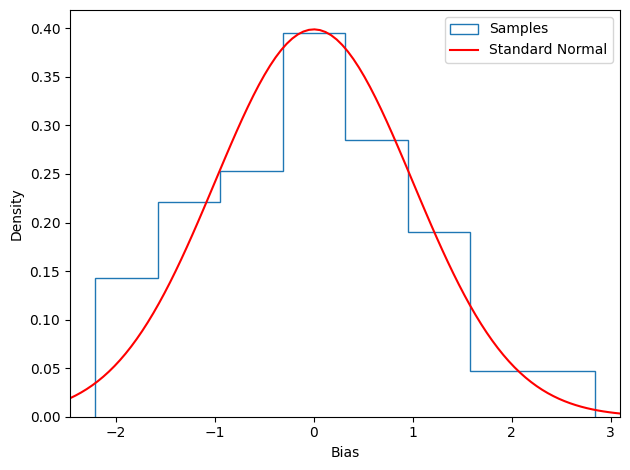

In [16]:
plt.figure()

plt.hist(bias, bins="auto", density=True, label="Samples", histtype="step")

xlim = plt.xlim()
xrange = np.linspace(*xlim, 100)
plt.plot(xrange, norm.pdf(xrange), label="Standard Normal", color='red')
plt.xlim(*xlim)

plt.xlabel("Bias")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.savefig("/Users/rstiskalek/Downloads/mock_test_H0.png", dpi=450)
plt.show()

### Recover back the total number of objects

In [85]:
from jax.scipy.stats.norm import logcdf as norm_logcdf
from quadax import simpson
from scipy.special import comb
from scipy.stats import norm

from jax.scipy.special import gammaln

def log_binom(N, n):
    N = jnp.asarray(N, )
    n = jnp.asarray(n, )
    valid = (n >= 0) & (n <= N) & jnp.isfinite(N) & jnp.isfinite(n)
    val = gammaln(N + 1.0) - gammaln(n + 1.0) - gammaln(N - n + 1.0)
    return jnp.where(valid, val, -jnp.inf)


def log_p_det(M, Rmax, mag_lim, e_mag):
    norm = jnp.log(3) + jnp.log(jnp.log(10)) - 3 * jnp.log(Rmax) - jnp.log(5) - 3 * M / 5 * jnp.log(10)

    grid_center = mag_lim - 25
    grid_left = grid_center - 10
    grid_right = grid_center + 20* e_mag

    x = jnp.linspace(grid_left, grid_right, 1000)
    log_y = 3 * x / 5 * jnp.log(10) + norm_logcdf((mag_lim - 25 - x) / e_mag)
    log_intg = jnp.log(simpson(jnp.exp(log_y), x=x))

    # plt.figure()
    # plt.plot(x, jnp.exp(log_y), label="logcdf")
    # plt.show()

    return norm + log_intg


def p_det_scipy(M, Rmax, mag_lim, e_mag):
    r = np.linspace(1e-5, Rmax, 1000)
    mu = r2mu(r)
    y = 3 * r**2 * norm().cdf((mag_lim - (M + mu)) / e_mag) / Rmax**3
    return simpson(y, x=r)


In [ ]:
N = np.arange(8000, 12_000)
n = 890

y = np.full(len(N), np.nan)
y2 = np.full(len(N), np.nan)
for i, Ni in enumerate(N):
    log_pS = jnp.log(p_det_scipy(M, Rmax, mag_lim, e_mag))
    log_pS_comp = jnp.log(-jnp.expm1(log_pS))
    y[i] = log_binom(Ni - 1, n - 1) + n * log_pS + (Ni - n) * log_pS_comp


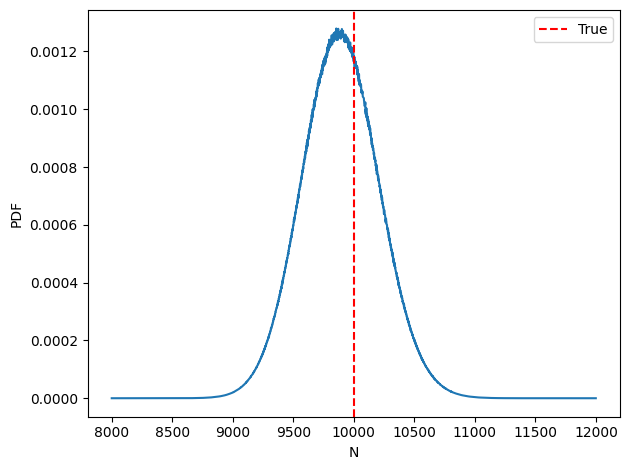

In [122]:
plt.figure()
plt.plot(N, jnp.exp(y))

plt.axvline(10_000, c="red", linestyle="--", label="True")

plt.xlabel("N")
plt.ylabel("PDF")
plt.legend()
plt.tight_layout()

plt.savefig("/Users/rstiskalek/Downloads/Ntest.png", dpi=450)

plt.show()

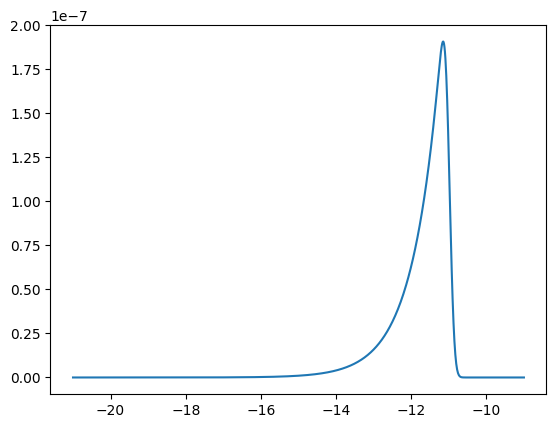

In [152]:
ps = log_p_det(M, Rmax, mag_lim, e_mag)

In [149]:
npoints * 0.66651535

6665.153499999999

In [66]:
grid_center = mag_lim - 25
grid_left = grid_center - 5
grid_right = grid_center + 20 * e_mag

x = jnp.linspace(grid_left, grid_right, 1000)

y = 3 * x / 5 * jnp.log(10) + norm_logcdf((mag_lim - 25 - x) / e_mag)
# y = norm_logcdf(x)

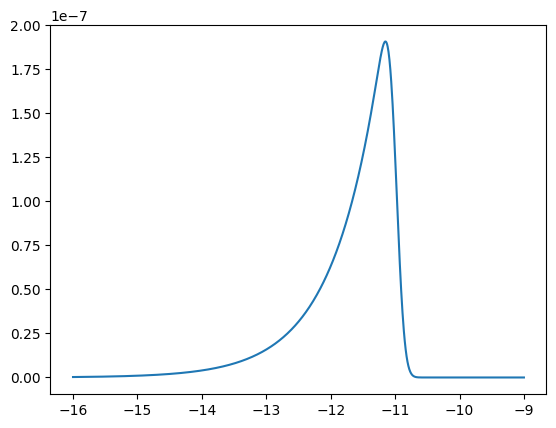

In [68]:
plt.figure()
plt.plot(x, jnp.exp(y), label="logcdf")

plt.show()